# This notebook explores, segments and clusters the neighborhoods in the city of Toronto

### _Import necessary dependencies_

In [1]:
from bs4 import BeautifulSoup as bs # for scraping
import requests # for sending web requests

# data manipulation
import pandas as pd
from pandas import json_normalize
import numpy as np

from geopy.geocoders import Nominatim # for obtaining the coordinates of an address

# visualization tools
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import inflect # for converting integers to ordinals

from sklearn.cluster import KMeans # for clustering


## 1) Web Scraping and Data Wrangling

### Web Scraping

**Send a GET request to the URL of the wikipedia page containing the data**

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html_content = requests.get(url).text

**Fetch and parse the data using BeautifulSoup**

In [3]:
soup = bs(html_content, "html5lib")

**View title of webpage without HTML tags**

In [4]:
soup.title.text

'List of postal codes of Canada: M - Wikipedia'

**Get table data and store it in a dictionary**

In [5]:
table = soup.find("table", attrs={"class": "wikitable"}).tbody.find_all("tr")

_Store table headers in a list_

In [6]:
headers = []

for th in table[0].find_all("th"):
    headers.append(th.text.replace("\n", " ").strip())

headers

['Postal Code', 'Borough', 'Neighborhood']

_Create an empty dictionary with the table headers as the keys_

In [7]:
table_data = {}
for header in headers:
    table_data[header] = []

table_data

{'Postal Code': [], 'Borough': [], 'Neighborhood': []}

_Populate the dictionary with the table data_

In [8]:
for i in range(1, len(table)):
    for header, td in zip(headers, table[i].find_all("td")):
        table_data[header].append(td.text.strip())

**Convert the dictionary to a dataframe**

In [9]:
toronto_df = pd.DataFrame(table_data)

**Save dataframe to a csv file**

In [10]:
toronto_df.to_csv("Toronto_postal_codes.csv")

### Data Wrangling

**Rename column**

In [11]:
toronto_df.rename(columns={"Postal Code": "PostalCode"}, inplace=True)

**Replace cells that have "Not assigned" values with nan**

In [12]:
toronto_df.replace("Not assigned", np.nan, inplace=True)

**Drop rows with nan values**

In [13]:
toronto_df.dropna(inplace=True)
toronto_df.reset_index(drop=True, inplace=True)

**View first 5 rows of dataframe**

In [14]:
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## Before moving forward, an important assumption needs to be made at this point. It is seen that there are multiple neighborhoods under some postal codes so those neighborhoods are assumed to be just one for ease of analysis

**Check for duplicate neighborhoods in dataframe**

In [15]:
toronto_df[toronto_df.duplicated(["Neighborhood"], keep=False)]

,PostalCode,Borough,Neighborhood
7,M3B,North York,Don Mills
13,M3C,North York,Don Mills
40,M3K,North York,Downsview
46,M3L,North York,Downsview
53,M3M,North York,Downsview
60,M3N,North York,Downsview


After research, it was discovered that there are no neighborhoods sharing the names Don Mills or Downsview in North York borough so the duplicates will be dropped 

**Drop duplicate neighborhoods**

In [16]:
toronto_df.drop_duplicates(["Neighborhood"], keep="first", inplace=True)

Check to see that the duplicates were dropped

In [17]:
toronto_df[toronto_df.duplicated(["Neighborhood"], keep=False)]

,PostalCode,Borough,Neighborhood


The duplicate neighborhoods were successfully dropped

**What is the size of the toronto_df dataframe?**

In [18]:
toronto_df.shape

(99, 3)

## 2) Obtain the coordinates of the neighborhoods


**Read the coordinates for the postal codes contained in a csv into a dataframe**

In [19]:
coordinates_df = pd.read_csv("Geospatial_Coordinates.csv")
coordinates_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**Merge the toronto_df dataframe with the coordinates_df dataframe**

In [20]:
toronto_df = toronto_df.set_index("PostalCode").join(coordinates_df.set_index("Postal Code")).reset_index()

**View the first few rows of the resulting dataframe**

In [21]:
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## 3) Explore and Cluster the Neighborhoods in Toronto

### Visualize the neighborhoods of Toronto on a map

**Get the coordinates of Toronto using the geopy library**

In [28]:
address = "Toronto, Canada"
locator = Nominatim(user_agent="ny_explorer")
location = locator.geocode(address)
latitude = location.latitude
longitude = location.longitude

**Create a map of Toronto showing the different neighborhoods**

In [29]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, label in zip(toronto_df["Latitude"], toronto_df["Longitude"], toronto_df["Neighborhood"]):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
toronto_map

**Get the different boroughs in Toronto**

In [30]:
toronto_df["Borough"].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [31]:
len(toronto_df["Borough"].unique())

10

There are 10 different boroughs in Toronto

**Let's see the distribution of neighborhoods in the different boroughs**

In [32]:
boroughs = toronto_df.groupby("Borough")["Neighborhood"].count()
boroughs

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          20
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

Let's visualize the distribution using a horizontal barplot

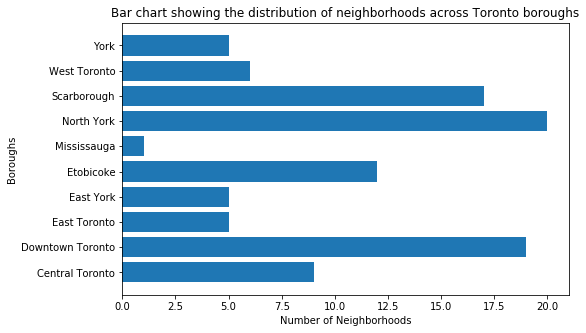

In [33]:
ax = plt.figure(figsize=(8, 5))
plt.barh(boroughs.index, boroughs)
plt.title("Bar chart showing the distribution of neighborhoods across Toronto boroughs")
plt.xlabel("Number of Neighborhoods")
plt.ylabel("Boroughs")
plt.show()

It can be seen from the plot that North York, Downtown Toronto, Scarborough and Etobicoke have the most concentration of neighborhoods

### Let's explore the neighborhoods in the York, North York and East York boroughs

**Create a dataframe of the "york" boroughs**

In [34]:
indexes = []
for index, row in toronto_df.iterrows():
    if row["Borough"].endswith("York"):
        indexes.append(index)

york_df = toronto_df.loc[indexes, :]
york_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937


How many neighborhoods are in the York boroughs?

In [35]:
york_df.shape

(30, 5)

There are 30 different neighborhoods in the York boroughs

**Now, let's visualize the neighborhoods on a map**

In [38]:
address = "York, Toronto, Canada"
locator = Nominatim(user_agent="ny_explorer")
location = locator.geocode(address)
york_latitude = location.latitude
york_longitude = location.longitude

In [39]:
york_map = folium.Map(location=[york_latitude, york_longitude], zoom_start=10)

for lat, lng, label in zip(york_df["Latitude"], york_df["Longitude"], york_df["Neighborhood"]):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(york_map)  

york_map

**Define Foursquare credentials and version**

In [40]:
CLIENT_ID = "MHJUWL4WN3DUWTZZZUVXB4EELKI4315Z4QS4ZCKZK4YN2A30" # Foursquare ID
CLIENT_SECRET = "CPD4MJ5AZXWBYQOUZVMOIYWUIJOJECHM54FLBXG12CHZF231" # Foursquare Secret
VERSION = "20180605" # Foursquare API version

print("Your credentials:")
print("CLIENT_ID: " + CLIENT_ID)
print("CLIENT_SECRET:" + CLIENT_SECRET)

Your credentials:
CLIENT_ID: MHJUWL4WN3DUWTZZZUVXB4EELKI4315Z4QS4ZCKZK4YN2A30
CLIENT_SECRET:CPD4MJ5AZXWBYQOUZVMOIYWUIJOJECHM54FLBXG12CHZF231


### Let's explore the one of the neighborhoods in the York Boroughs

**Get the neighborhood's name and coordinates**

In [41]:
neighborhood_latitude = york_df.loc[1, "Latitude"] # neighborhood latitude value
neighborhood_longitude = york_df.loc[1, "Longitude"] # neighborhood longitude value

neighborhood_name = york_df.loc[1, "Neighborhood"] # neighborhood name

print(f"Latitude and longitude values of {neighborhood_name} are {neighborhood_latitude}, {neighborhood_longitude}")

Latitude and longitude values of Victoria Village are 43.725882299999995, -79.31557159999998


**Let's get the top 50 venues within a 500 metres radius of the neighborhood** 

Make an explore call to the Foursquare API and get the results

In [42]:
LIMIT = 50
RADIUS = 500

url = f"https://api.foursquare.com/v2/venues/explore?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}\
&ll={neighborhood_latitude}, {neighborhood_longitude}&v={VERSION}&radius={RADIUS}&limit={LIMIT}"

results = requests.get(url).json()

View the results of the explore call

In [43]:
results

{'meta': {'code': 200, 'requestId': '5eedd4781187ee001b77d717'},
 'response': {'headerLocation': 'Bermondsey',
  'headerFullLocation': 'Bermondsey, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 43.7303823045, 'lng': -79.30935618239715},
   'sw': {'lat': 43.72138229549999, 'lng': -79.32178701760282}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c633acb86b6be9a61268e34',
       'name': 'Victoria Village Arena',
       'location': {'lat': 43.72348055545508,
        'lng': -79.31563520925143,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.72348055545508,
          'lng': -79.31563520925143}],
        'distance': 267,
        'cc': 'CA',
        'country': 'Canada',
        'formatte

The results in the above form do not make much sense so let's clean and process it into a more understandable form

**Define a function that extracts the category of a venue**

In [44]:
def get_category_type(row):
    try:
        categories_list = row["categories"]
    except:
        categories_list = row["venue.categories"]
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]["name"]

**Clean and process the json file into a dataframe**

In [45]:
venues = results["response"]["groups"][0]["items"]
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ["venue.name", "venue.categories", "venue.location.lat", "venue.location.lng"]
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues["venue.categories"] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

View the first few rows of the resulting dataframe

In [46]:
nearby_venues.head()

,name,categories,lat,lng
0,Victoria Village Arena,Hockey Arena,43.723481,-79.315635
1,Portugril,Portuguese Restaurant,43.725819,-79.312785
2,Tim Hortons,Coffee Shop,43.725517,-79.313103
3,The Frig,French Restaurant,43.727051,-79.317418
4,Pizza Nova,Pizza Place,43.725824,-79.312860


How many venues were returned for Victoria Village?

In [47]:
nearby_venues.shape[0]

5

5 venues were returned for Victoria Village by Foursquare

**Now, let's create and apply a function to return the venues for all neighborhoods in York**

In [70]:
def getNearbyVenues(names, latitudes, longitudes):
    radius = 500
    LIMIT = 50
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = f"https://api.foursquare.com/v2/venues/explore?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}\
        &ll={lat}, {lng}&v={VERSION}&radius={RADIUS}&limit={LIMIT}"
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v["venue"]["name"], 
            v["venue"]["location"]["lat"], 
            v["venue"]["location"]["lng"],  
            v["venue"]["categories"][0]["name"]) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ["Neighborhood", 
                  "Neighborhood Latitude", 
                  "Neighborhood Longitude", 
                  "Venue", 
                  "Venue Latitude", 
                  "Venue Longitude", 
                  "Venue Category"]
    
    return(nearby_venues)

In [74]:
york_venues = getNearbyVenues(york_df["Neighborhood"], york_df["Latitude"], york_df["Longitude"])

**Let's view the first few rows of the resulting dataframe**

In [75]:
york_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


**Check how many venues were returned by the Foursquare API**

In [76]:
york_venues.shape

(289, 7)

**How many unique venue categories are there?**

In [77]:
len(york_venues["Venue Category"].unique())

119

There are 123 unique venue categories

**Check the top 5 neighborhoods with the most venues**

In [81]:
york_venues.groupby("Neighborhood")["Venue"].count().sort_values(ascending=False)[:5]

Neighborhood
Fairview, Henry Farm, Oriole                       50
Willowdale, Willowdale East                        34
Leaside                                            32
Bedford Park, Lawrence Manor East                  24
Bathurst Manor, Wilson Heights, Downsview North    22
Name: Venue, dtype: int64

**Create dummy variables for each unique category**

In [82]:
categories = pd.get_dummies(york_venues["Venue Category"])
categories.head()

,Accessories Store,Airport,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bank,Bar,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Add a **Neighborhood** column to the **categories** dataframe

In [83]:
current_columns = categories.columns.to_list()
categories["Neighborhood"] = york_venues["Neighborhood"]
categories = categories[["Neighborhood"] + current_columns]
categories.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bank,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
categories.shape

(289, 120)

**Let's group the dataframe by Neighborhood and take the mean of each category**

In [85]:
york_categories = categories.groupby("Neighborhood").mean().reset_index().round(4)
york_categories.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bagel Shop,Bakery,Bank,...,Thai Restaurant,Theater,Toy / Game Store,Trail,Turkish Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Women's Store,Yoga Studio
0,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0909,...,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,Bayview Village,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.2500,...,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0417,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0417,0.0,0.0417,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,Caledonia-Fairbanks,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.25,0.0
4,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0000,0.0,0.0000,0.0,0.2,0.0,0.0,0.0,0.00,0.0


Examine the size of the **york_categories** dataframe

In [86]:
york_categories.shape

(29, 120)

**Let's print each neighborhood along with its top 5 venue categories**

In [87]:
num_top_venues = 5

for hood in york_categories["Neighborhood"]:
    print("----"+hood+"----")
    temp = york_categories[york_categories["Neighborhood"] == hood].T.reset_index()
    temp.columns = ["venue category","frequency"]
    temp = temp.iloc[1:]
    temp["frequency"] = temp["frequency"].astype(float)
    temp = temp.round({"frequency": 2})
    print(temp.sort_values(by="frequency", ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bathurst Manor, Wilson Heights, Downsview North----
        venue category  frequency
0          Coffee Shop       0.09
1                 Bank       0.09
2                 Park       0.05
3        Shopping Mall       0.05
4  Fried Chicken Joint       0.05


----Bayview Village----
        venue category  frequency
0                 Bank       0.25
1                 Café       0.25
2  Japanese Restaurant       0.25
3   Chinese Restaurant       0.25
4    Mobile Phone Shop       0.00


----Bedford Park, Lawrence Manor East----
       venue category  frequency
0  Italian Restaurant       0.08
1          Restaurant       0.08
2      Sandwich Place       0.08
3         Coffee Shop       0.08
4      Cosmetics Shop       0.04


----Caledonia-Fairbanks----
      venue category  frequency
0               Park       0.50
1      Women's Store       0.25
2               Pool       0.25
3  Accessories Store       0.00
4      Metro Station       0.00


----Del Ray, Mount Dennis, Keelsdale and Sil

**Let's now create a dataframe showing the top 10 venue categories for each neighborhood**

In [101]:
columns = ["Neighborhood"]

for i in range(1, 11):
    columns.append(f"{inflect.engine().ordinal(i)} Most Common")

york = pd.DataFrame(columns=columns)
york["Neighborhood"] = york_categories["Neighborhood"]

for index, row in york_categories.iterrows():
    york.iloc[index, 1:] = row.iloc[1:].sort_values(ascending=False).index[:10]

york.head()
    

,Neighborhood,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Chinese Restaurant,Sandwich Place,Restaurant,Pizza Place,Pharmacy,Park,Mobile Phone Shop,Bridal Shop
1,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Yoga Studio,Field,Curling Ice,Deli / Bodega,Department Store,Dessert Shop
2,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Pizza Place,Indian Restaurant,Cosmetics Shop,Pharmacy,Café,Butcher
3,Caledonia-Fairbanks,Park,Women's Store,Pool,Yoga Studio,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store
4,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",Convenience Store,Turkish Restaurant,Sandwich Place,Skating Rink,Discount Store,Yoga Studio,Event Space,Construction & Landscaping,Cosmetics Shop,Curling Ice


### Cluster the Neighborhoods using K-Means

**Get a features dataframe for fitting**

In [89]:
features = york_categories.drop("Neighborhood", axis=1)

**Determine the best k value to use for the model**

In [90]:
clusters = list(range(3, 8))
score = []
for cluster in clusters:
    kmean = KMeans(init="k-means++", n_clusters=cluster, n_init=28, random_state=6)
    kmean.fit(features)
    score.append(kmean.inertia_)

Visualization to determine the elbow point

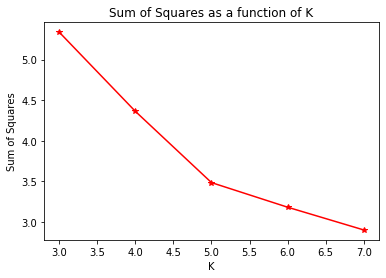

In [91]:
plt.plot(clusters, score, color="red", marker="*")
plt.title("Sum of Squares as a function of K")
plt.xlabel("K")
plt.ylabel("Sum of Squares")
plt.show()

**From the plot shown above, it is seen that the elbow point is at K = 5**

**Build and fit the model**

In [92]:
kmean = KMeans(init="k-means++", n_clusters=5, n_init=12, random_state=0)
kmean.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

**Obtain the predicted labels**

In [93]:
labels = kmean.labels_
labels[:5]

array([1, 1, 1, 4, 1])

**Append the labels predicted by the model to their respective neighborhoods**

In [103]:
#york.drop("Cluster Labels", axis=1, inplace=True)
york.insert(0, "Cluster Labels", labels)
york.head()

,Cluster Labels,Neighborhood,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,1,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Chinese Restaurant,Sandwich Place,Restaurant,Pizza Place,Pharmacy,Park,Mobile Phone Shop,Bridal Shop
1,1,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Yoga Studio,Field,Curling Ice,Deli / Bodega,Department Store,Dessert Shop
2,1,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Pizza Place,Indian Restaurant,Cosmetics Shop,Pharmacy,Café,Butcher
3,4,Caledonia-Fairbanks,Park,Women's Store,Pool,Yoga Studio,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store
4,1,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",Convenience Store,Turkish Restaurant,Sandwich Place,Skating Rink,Discount Store,Yoga Studio,Event Space,Construction & Landscaping,Cosmetics Shop,Curling Ice


**Obtain a single dataframe containing all key pieces of information about each neighborhood**

In [104]:
york_merged = york_df.merge(york, on="Neighborhood")
york_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,Construction & Landscaping,Park,Food & Drink Shop,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store,Dessert Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Hockey Arena,Coffee Shop,French Restaurant,Pizza Place,Portuguese Restaurant,Asian Restaurant,Field,Cosmetics Shop,Curling Ice,Deli / Bodega
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,Clothing Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Miscellaneous Shop,Coffee Shop,Shoe Store,Accessories Store,Vietnamese Restaurant
3,M3B,North York,Don Mills,43.745906,-79.352188,1,Gym / Fitness Center,Caribbean Restaurant,Athletics & Sports,Café,Japanese Restaurant,Field,Curling Ice,Deli / Bodega,Department Store,Dessert Shop
4,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,1,Pizza Place,Breakfast Spot,Bank,Gym / Fitness Center,Café,Fast Food Restaurant,Intersection,Pharmacy,Athletics & Sports,Gastropub


**Visualize the various clusters of the neighborhoods on a map**

In [96]:
# create map
map_clusters = folium.Map(location=[york_latitude, york_longitude], zoom_start=11)

# set color scheme for the clusters
kclusters = 5
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in\
zip(york_merged["Latitude"], york_merged["Longitude"], york_merged["Neighborhood"], york_merged["Cluster Labels"]):
    
    label = folium.Popup(str(poi) + " Cluster " + str(cluster + 1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

It is seen from the map that most of the neighborhoods belong to a particular cluster 

**Let's check the number of neighborhoods in each cluster**

In [97]:
york_merged.groupby("Cluster Labels")["Neighborhood"].count()

Cluster Labels
0     1
1    22
2     1
3     1
4     4
Name: Neighborhood, dtype: int64

### Let's examine the neighborhoods under each cluster

### Cluster 1

In [105]:
cluster1 = york_merged.loc[york_merged['Cluster Labels'] == 0,\
                york_merged.columns[[1] + [2] + list(range(6, york_merged.shape[1]))]]
cluster1

,Borough,Neighborhood,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
23,North York,"Humberlea, Emery",Baseball Field,Yoga Studio,Field,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Diner


### Cluster 2

In [106]:
cluster2 = york_merged.loc[york_merged['Cluster Labels'] == 1,\
                york_merged.columns[[1] + [2] + list(range(6, york_merged.shape[1]))]]

cluster2

,Borough,Neighborhood,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,North York,Parkwoods,Construction & Landscaping,Park,Food & Drink Shop,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store,Dessert Shop
1,North York,Victoria Village,Hockey Arena,Coffee Shop,French Restaurant,Pizza Place,Portuguese Restaurant,Asian Restaurant,Field,Cosmetics Shop,Curling Ice,Deli / Bodega
2,North York,"Lawrence Manor, Lawrence Heights",Clothing Store,Boutique,Gift Shop,Furniture / Home Store,Event Space,Miscellaneous Shop,Coffee Shop,Shoe Store,Accessories Store,Vietnamese Restaurant
3,North York,Don Mills,Gym / Fitness Center,Caribbean Restaurant,Athletics & Sports,Café,Japanese Restaurant,Field,Curling Ice,Deli / Bodega,Department Store,Dessert Shop
4,East York,"Parkview Hill, Woodbine Gardens",Pizza Place,Breakfast Spot,Bank,Gym / Fitness Center,Café,Fast Food Restaurant,Intersection,Pharmacy,Athletics & Sports,Gastropub
5,North York,Glencairn,Pizza Place,Pub,Bakery,Japanese Restaurant,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store
6,East York,Woodbine Heights,Pharmacy,Park,Skating Rink,Curling Ice,Athletics & Sports,Beer Store,Spa,Bus Stop,Diner,Dog Run
7,York,Humewood-Cedarvale,Hockey Arena,Trail,Tennis Court,Field,Cosmetics Shop,Curling Ice,Convenience Store,Deli / Bodega,Fast Food Restaurant,Dessert Shop
9,East York,Leaside,Coffee Shop,Burger Joint,Furniture / Home Store,Bank,Sporting Goods Shop,Smoothie Shop,Sports Bar,Restaurant,Liquor Store,Sandwich Place
10,North York,Hillcrest Village,Pool,Mediterranean Restaurant,Golf Course,Dog Run,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store


### Cluster 3

In [108]:
cluster3 = york_merged.loc[york_merged['Cluster Labels'] == 2,\
                york_merged.columns[[1] + [2] + list(range(6, york_merged.shape[1]))]]

cluster3

,Borough,Neighborhood,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
18,North York,"York Mills, Silver Hills",Martial Arts Dojo,Yoga Studio,Field,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Diner


### Cluster 4 

In [109]:
cluster4 = york_merged.loc[york_merged['Cluster Labels'] == 3,\
                york_merged.columns[[1] + [2] + list(range(6, york_merged.shape[1]))]]
cluster4

,Borough,Neighborhood,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
20,North York,Humber Summit,Pizza Place,Yoga Studio,Health Food Store,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Diner


### Cluster 5

In [111]:
cluster5 = york_merged.loc[york_merged['Cluster Labels'] == 4,\
                york_merged.columns[[1] + [2] + list(range(6, york_merged.shape[1]))]]
cluster5

,Borough,Neighborhood,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
8,York,Caledonia-Fairbanks,Park,Women's Store,Pool,Yoga Studio,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store
15,East York,"East Toronto, Broadview North (Old East York)",Park,Convenience Store,Rental Car Location,Yoga Studio,Comfort Food Restaurant,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store,Dessert Shop
26,York,Weston,Convenience Store,Park,Yoga Studio,Health Food Store,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Diner
27,North York,York Mills West,Convenience Store,Park,Moving Target,Bar,Fast Food Restaurant,Cosmetics Shop,Curling Ice,Deli / Bodega,Department Store,Dessert Shop


# This is the end of the notebook. Thank you for viewing it.
# Author: Olaleke, Moshood A.
